In [1]:
pip install skforecast


  Using cached skforecast-0.5.1-py2.py3-none-any.whl (169 kB)
  Using cached scikit_optimize-0.9.0-py2.py3-none-any.whl (100 kB)
  Using cached optuna-2.10.0-py3-none-any.whl (308 kB)
  Using cached matplotlib-3.5.0-cp37-cp37m-win_amd64.whl (7.2 MB)
  Using cached seaborn-0.11.0-py3-none-any.whl (283 kB)
  Using cached cliff-3.10.1-py3-none-any.whl (81 kB)
  Using cached alembic-1.8.1-py3-none-any.whl (209 kB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.3
    Uninstalling matplotlib-3.5.3:
      Successfully uninstalled matplotlib-3.5.3
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.1
    Uninstalling seaborn-0.12.1:
      Successfully uninstalled seaborn-0.12.1


In [ ]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('fivethirtyeight')

# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [164]:
# Descarga de datos
# ==============================================================================
arch = ('completo_ok.csv')
datos = pd.read_csv(arch)
datos.info()
datos.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7295 entries, 0 to 7294
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           7295 non-null   int64  
 1   Fecha        7295 non-null   object 
 2   Dia          7295 non-null   int64  
 3   Demanda      7295 non-null   int64  
 4   Temperatura  7295 non-null   float64
 5   Feriado      7295 non-null   int64  
 6   Publico      7295 non-null   int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 399.1+ KB


,ID,Fecha,Dia,Demanda,Temperatura,Feriado,Publico
0,0,2021/07/01 00:00,4,1721748533,8.7,0,0
1,1,2021/07/01 01:00,4,1731462994,8.4,0,0
2,2,2021/07/01 02:00,4,1676358588,8.2,0,0
3,3,2021/07/01 03:00,4,1653972981,7.7,0,0
4,4,2021/07/01 04:00,4,1653886127,7.2,0,0


In [165]:
# Conversión del formato fecha
# ==============================================================================
datos['Fecha'] = pd.to_datetime(datos['Fecha'])
datos = datos.set_index('Fecha')
datos = datos.asfreq('60min')
datos = datos.sort_index()

In [166]:
# Verificar que un índice temporal está completo
# ==============================================================================
(datos.index == pd.date_range(start=datos.index.min(),
                              end=datos.index.max(),
                              freq=datos.index.freq)).all()

True

In [167]:
# Separación datos train-val-test
# ==============================================================================
datos = datos.loc['2021-07-01 00:00:00': '2022-05-01 23:00:00']
fin_train = '2021-10-31 23:59:00'
fin_validacion = '2022-01-01 00:00:00'
datos_train = datos.loc[: fin_train, :]
datos_val   = datos.loc[fin_train:fin_validacion, :]
datos_test  = datos.loc[fin_validacion:, :]

print(f"Fechas train      : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas validacion : {datos_val.index.min()} --- {datos_val.index.max()}  (n={len(datos_val)})")
print(f"Fechas test       : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

Fechas train      : 2021-07-01 00:00:00 --- 2021-10-31 23:00:00  (n=2952)
Fechas validacion : 2021-11-01 00:00:00 --- 2022-01-01 00:00:00  (n=1465)
Fechas test       : 2022-01-01 00:00:00 --- 2022-05-01 00:00:00  (n=2881)


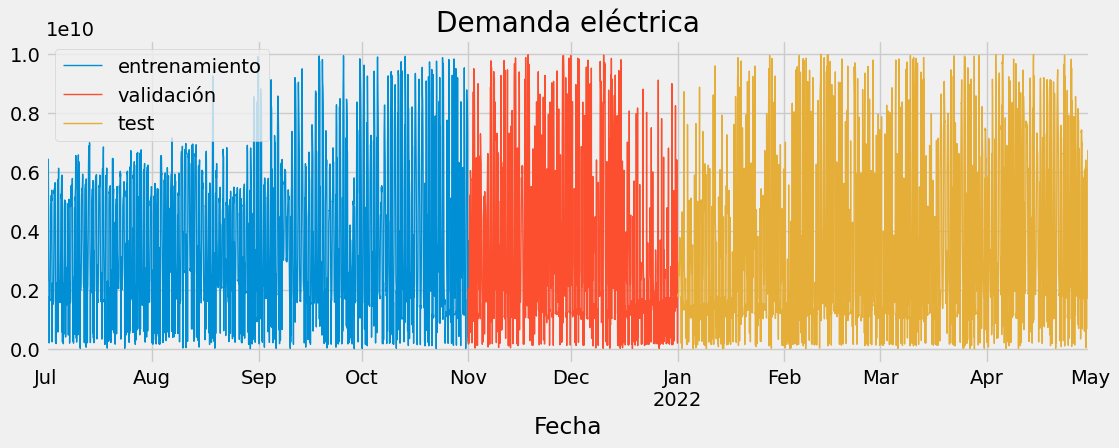

In [168]:
# Gráfico serie temporal
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 4))
datos_train.Demanda.plot(ax=ax, label='entrenamiento', linewidth=1)
datos_val.Demanda.plot(ax=ax, label='validación', linewidth=1)
datos_test.Demanda.plot(ax=ax, label='test', linewidth=1)
ax.set_title('Demanda eléctrica')
ax.legend();

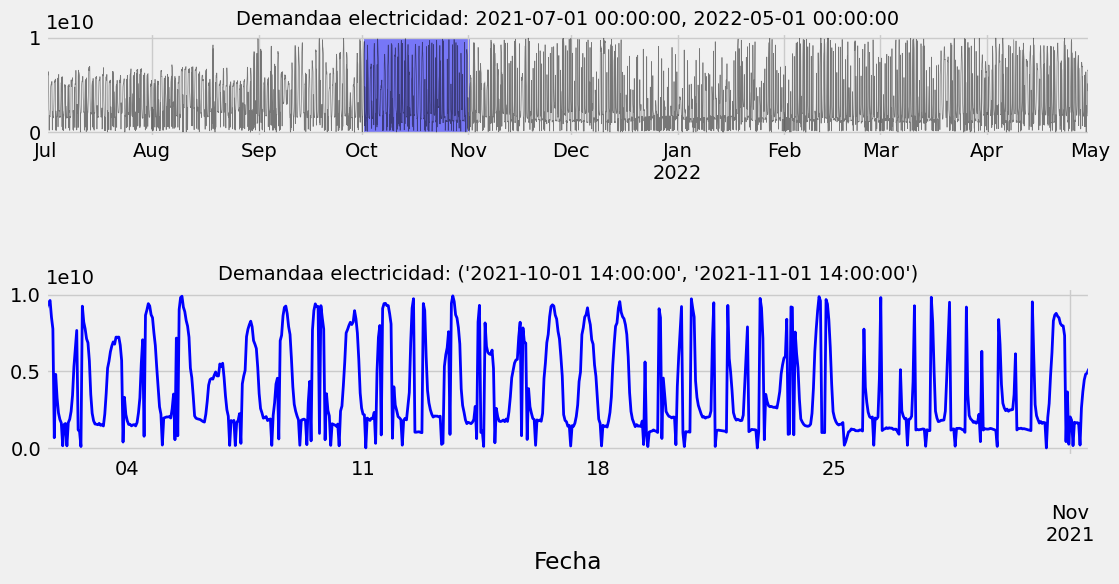

In [12]:
# Gráfico serie temporal con zoom
# ==============================================================================
zoom = ('2021-10-01 14:00:00','2021-11-01 14:00:00')

fig = plt.figure(figsize=(12, 6))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.6, wspace=0)

main_ax = fig.add_subplot(grid[1:3, :])
zoom_ax = fig.add_subplot(grid[5:, :])

datos.Demanda.plot(ax=main_ax, c='black', alpha=0.5, linewidth=0.5)
min_y = min(datos.Demanda)
max_y = max(datos.Demanda)
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_xlabel('')

datos.loc[zoom[0]: zoom[1]].Demanda.plot(ax=zoom_ax, color='blue', linewidth=2)

main_ax.set_title(f'Demandaa electricidad: {datos.index.min()}, {datos.index.max()}', fontsize=14)
zoom_ax.set_title(f'Demandaa electricidad: {zoom}', fontsize=14)
plt.subplots_adjust(hspace=1)

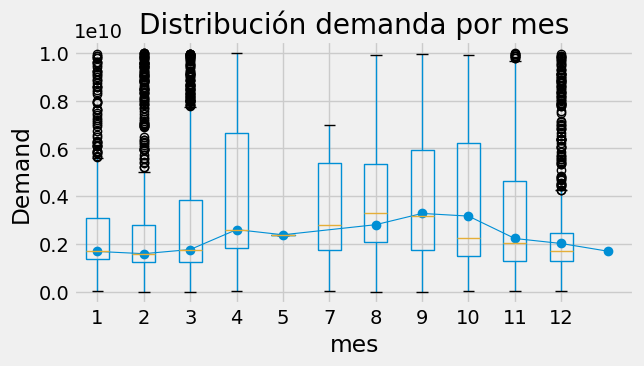

In [13]:
# Gráfico boxplot para estacionalidad anual
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3.5))
datos['mes'] = datos.index.month
datos.boxplot(column='Demanda', by='mes', ax=ax,)
datos.groupby('mes')['Demanda'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Distribución demanda por mes')
fig.suptitle('');

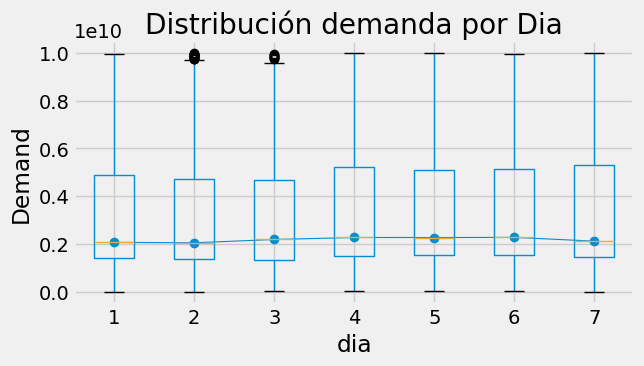

In [25]:
# Gráfico boxplot para estacionalidad semanal
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3.5))
datos['dia'] = datos.index.day_of_week+1
datos.boxplot(column='Demanda', by='dia', ax=ax,)
datos.groupby('dia')['Demanda'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Distribución demanda por Dia')
fig.suptitle('');

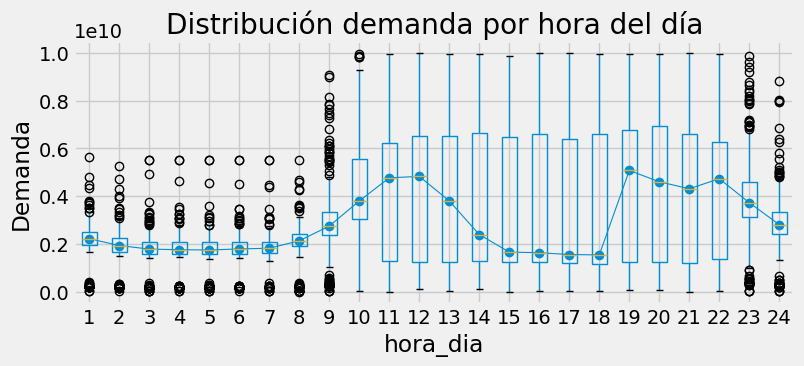

In [20]:
# Gráfico boxplot para estacionalidad diaria
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 3.5))
datos['hora_dia'] = datos.index.hour + 1
datos.boxplot(column='Demanda', by='hora_dia', ax=ax)
datos.groupby('hora_dia')['Demanda'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demanda')
ax.set_title('Distribución demanda por hora del día')
fig.suptitle('');

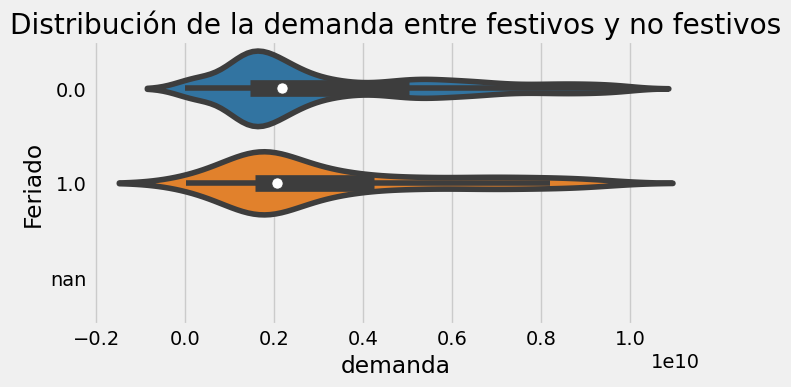

In [28]:
# Grafico violinplot
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 3.5))
sns.violinplot(
    x       = 'Demanda',
    y       = 'Feriado',
    data    = datos.assign(Feriado = datos.Feriado.astype(str)),
    palette = 'tab10',
    ax      = ax
)
ax.set_title('Distribución de la demanda entre festivos y no festivos')
ax.set_xlabel('demanda')
ax.set_ylabel('Feriado');

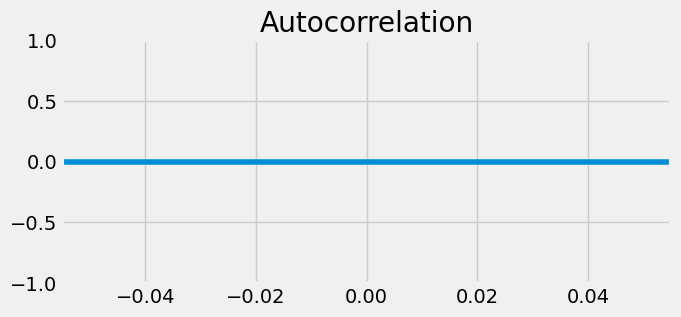

In [29]:
# Gráfico autocorrelación
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
plot_acf(datos.Demanda, ax=ax, lags=60)
plt.show()

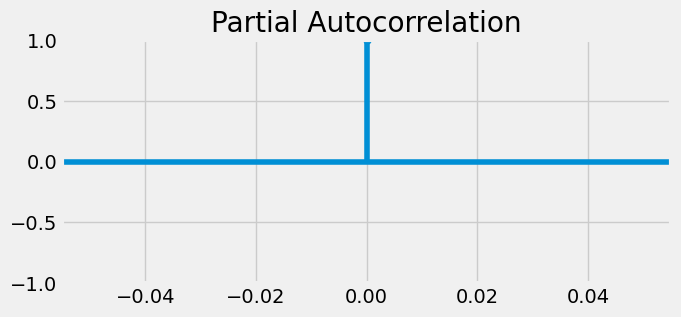

In [30]:
# Gráfico autocorrelación parcial
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
plot_pacf(datos.Demanda, ax=ax, lags=60)
plt.show()


In [218]:
#### Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 6
             )

forecaster.fit(y=datos_train['Demanda'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2021-07-01 00:00:00'), Timestamp('2021-10-31 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: 60T 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-11-25 16:42:45 
Last fit date: 2022-11-25 16:42:48 
Skforecast version: 0.5.1 
Python version: 3.7.13 

In [205]:
steps = 2952
predictions = forecaster.predict(steps=steps)
predictions

2021-11-01 00:00:00    3.158810e+09
2021-11-01 01:00:00    2.090832e+09
2021-11-01 02:00:00    1.636805e+09
2021-11-01 03:00:00    1.311563e+09
2021-11-01 04:00:00    1.270423e+09
                           ...     
2022-03-03 19:00:00    1.545436e+09
2022-03-03 20:00:00    1.567894e+09
2022-03-03 21:00:00    1.483176e+09
2022-03-03 22:00:00    1.506095e+09
2022-03-03 23:00:00    1.512546e+09
Freq: 60T, Name: pred, Length: 2952, dtype: float64

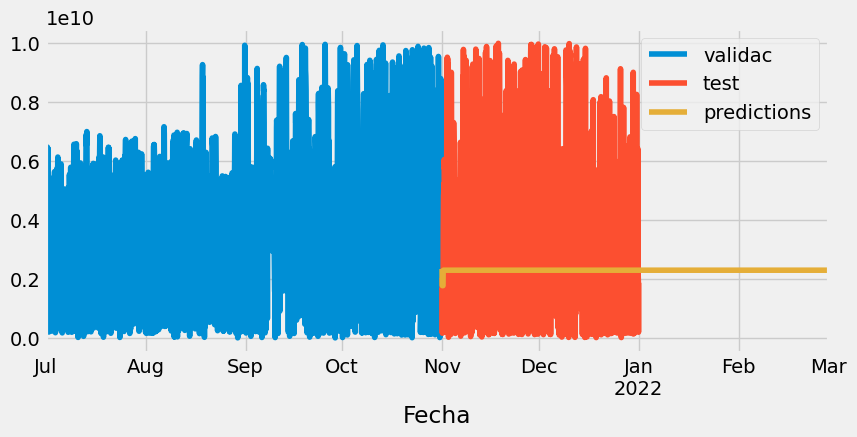

In [231]:
fig, ax = plt.subplots(figsize=(9, 4))
datos_train['Demanda'].plot(ax=ax, label='validac')
datos_val['Demanda'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [232]:
# Test error
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster
error_mse = mean_squared_error(
                y_true = datos_test['Demanda'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [220]:
# Hyperparameter Grid search
# ==============================================================================
steps = 36
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [10, 20]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = datos_train['Demanda'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(datos_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 12.


loop lags_grid: 100%|███████████████████████████████████| 2/2 [1:30:34<00:00, 2717.35s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 3, 'n_estimators': 100}
  Backtesting metric: 6.322460686687835e+18



In [221]:
# Grid Search results
# ==============================================================================
results_grid

,lags,params,mean_squared_error,max_depth,n_estimators
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",6.322461e+18,3,100
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 500}",6.337914e+18,3,500
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",6.495723e+18,5,500
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",6.678454e+18,5,100
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 100}",6.877264e+18,3,100
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 500}",6.933692e+18,10,500
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 500}",6.999221e+18,3,500
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 500}",7.047270e+18,5,500
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",7.145460e+18,5,100
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 500}",7.362170e+18,10,500


In [223]:
# Create and train forecaster with the best hyperparameters
# ==============================================================================
regressor = RandomForestRegressor(max_depth=3, n_estimators=500, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 20
             )

forecaster.fit(y=datos_train['Demanda'])

In [233]:
# Predictions
# ==============================================================================
steps = 2881
predictions = forecaster.predict(steps=steps)
predictions

2021-11-01 00:00:00    2.338039e+09
2021-11-01 01:00:00    1.776301e+09
2021-11-01 02:00:00    1.772524e+09
2021-11-01 03:00:00    1.772524e+09
2021-11-01 04:00:00    1.772524e+09
                           ...     
2022-02-28 20:00:00    2.296137e+09
2022-02-28 21:00:00    2.296137e+09
2022-02-28 22:00:00    2.296137e+09
2022-02-28 23:00:00    2.296137e+09
2022-03-01 00:00:00    2.296137e+09
Freq: 60T, Name: pred, Length: 2881, dtype: float64

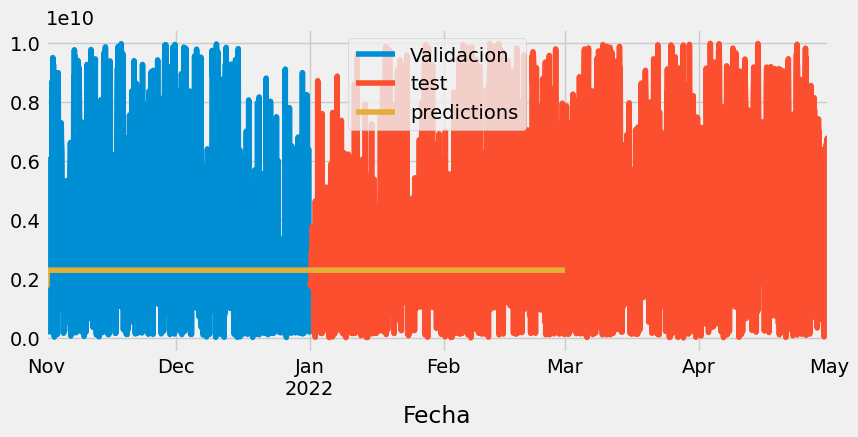

In [238]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos_val['Demanda'].plot(ax=ax, label='Validacion')
datos_test['Demanda'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [237]:
## Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_val['Demanda'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

ValueError: Found input variables with inconsistent numbers of samples: [1465, 2881]

Modelo direct multi-step


Los modelos ForecasterAutoreg siguen una estrategia de predicción recursiva en la que, cada nueva predicción, se basa en la predicción anterior. Una alternativa es entrenar un modelo para cada uno de los steps que se desea predecir, lo que se conoce como direct multi-step forecasting. Si bien es computacionalmente más costosa que la recursiva, puesto que requiere entrenar múltiples modelos, en algunos escenarios, consigue mejores resultados. Este tipo de modelos pueden obtenerse con la clase ForecasterAutoregDirect y pueden incluir también una o múltiples variables exógenas.

Entrenamiento y tuning del Forecaster


A diferencia de cuando se utiliza ForecasterAutoreg, en los modelos de tipo ForecasterAutoregDirect hay que indicar, en el momento de su creación, el número máximo de steps que se quieren predecir.

In [ ]:
# Grid search de hiperparámetros
# ==============================================================================
forecaster = ForecasterAutoregDirect(
                regressor = LGBMRegressor(max_depth=4),
                steps     = 36,
                lags      = 24 # Este valor será remplazado en el grid search
             )

# Lags utilizados como predictores
lags_grid = [[1, 2, 3, 23, 24], [1, 2, 3, 23, 24, 25, 47, 48, 49]]

# Hiperparámetros del regresor
param_grid = {'n_estimators': [100, 500],
              'max_depth': [4, 6]}

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = datos.loc[:fin_validacion, 'Demanda'],
                        exog               = datos.loc[:fin_validacion, 'Temperatura'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = 36,
                        metric             = 'mean_absolute_error',
                        refit              = False,
                        initial_train_size = len(datos.loc[:fin_train]),
                        return_best        = True,
                        verbose            = False
                  )

In [ ]:
# Backtest
# ==============================================================================
predicciones = backtest_predict_next_24h(
                    forecaster = forecaster,
                    y          = datos.loc[fin_validacion:, 'Demanda'],
                    exog       = datos.loc[fin_validacion:, exog],
                    hour_init_prediction = 11,
                    verbose    = False
               )

In [ ]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 3.5))
datos.loc[predicciones.index, 'Demanda'].plot(linewidth=2, label='test', ax=ax)
predicciones.plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend();

In [ ]:
# Error backtest
# ==============================================================================
error = mean_absolute_error(
            y_true = datos.loc[predicciones.index, 'TOTAL KW'],
            y_pred = predicciones
        )

print(f"Error de backtest: {error}")